In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

In [3]:
pd.set_option('display.max_columns', 100)

pd.set_option('display.max_rows', 200)

In [4]:
data_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
data_test.shape


(1459, 80)

In [5]:
def cleanData(data_cleaned):
  data_cleaned = data_cleaned.drop('Id', axis = 1)
  imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
  numeric_features = list(data_cleaned.dtypes[(data_cleaned.dtypes != "str") & (data_cleaned.dtypes !='object')].index)
  numeric_features.__len__()
  remove_list = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','BedroomAbvGr','KitchenAbvGr','MoSold','YrSold','GarageYrBlt'];
  numeric_features = np.setdiff1d(numeric_features, remove_list).tolist()
  numeric_features.__len__()
  data_cleaned[numeric_features] = pd.DataFrame(imputer.fit_transform(data_cleaned[numeric_features]))
  catogericalImputer = SimpleImputer(strategy='constant',fill_value='NA', missing_values=np.nan)
  catogericalMissingData= ['BsmtQual','BsmtCond','BsmtFinType1','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','MiscFeature','PoolQC','FireplaceQu']
  data_cleaned[catogericalMissingData] = pd.DataFrame(catogericalImputer.fit_transform(data_cleaned[catogericalMissingData]))
  data_cleaned.loc[(data_cleaned['BsmtCond']=='NA') & (data_cleaned['BsmtExposure'].isnull()), 'BsmtExposure'] = 'NA'
  data_cleaned.loc[(data_cleaned['BsmtCond']=='NA') & (data_cleaned['BsmtFinType2'].isnull()), 'BsmtFinType2'] = 'NA'
  data_cleaned.loc[(data_cleaned['BsmtCond']=='NA') & (data_cleaned['BsmtFinType2'].isnull()), 'BsmtFinType2'] = 'NA'
  #Since most of the data in Fence, Alley are missing. It would bias the data if we impute them.
  data_cleaned = data_cleaned.drop(['Fence','Alley'], axis = 1)
  #drop unnecessary columns
  # data_cleaned['BldgAge'] = (data_cleaned['YrSold'] - data_cleaned['YearBuilt'])
  data_cleaned['BldgAge'] = np.where(data_cleaned["YrSold"] > data_cleaned["YearBuilt"],(data_cleaned['YrSold'] - data_cleaned['YearBuilt']),0)
  data_cleaned["isRemodelled"] = np.where(data_cleaned["YearRemodAdd"] > data_cleaned["YearBuilt"], 1, 0)
  data_cleaned["isPool"] = np.where(data_cleaned["PoolQC"] == 'NA', 0, 1)
  drop_columns = ['YrSold','YearBuilt','MoSold','YearRemodAdd','GarageYrBlt']
  data_cleaned = data_cleaned.drop(drop_columns, axis = 1)
  drop_columns2= ['MSZoning', 
                  'Street',
                  # 'LandContour',
                  'LandSlope',
                  'Condition1','Condition2',
                  # 'RoofStyle',
                  'RoofMatl',
                  # 'MasVnrArea',
                  'ExterCond',
                  'BsmtCond',
                  # 'BsmtFinType2',
                  # 'BsmtFinSF2'
                  ]
  drop_columns3= ['Electrical','LowQualFinSF',
                  'Functional',
                  'ScreenPorch',
                  'MiscVal']
  # drop_columns4=['isRemodelled','isPool']

  data_cleaned = data_cleaned.drop(drop_columns2, axis = 1)
  data_cleaned = data_cleaned.drop(drop_columns3, axis = 1)
  # data_cleaned = data_cleaned.drop(drop_columns4, axis = 1)
  Features = data_cleaned.columns
  New_numeric_features = list(data_cleaned.dtypes[(data_cleaned.dtypes != "str") & (data_cleaned.dtypes !='object')].index)
  Catogery_feature = np.setdiff1d(Features, New_numeric_features).tolist()
  # Label Encoding catogery features
  data_cleaned[Catogery_feature] = data_cleaned[Catogery_feature].apply(LabelEncoder().fit_transform)

  return data_cleaned


In [6]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def trainmodel(data_cleaned):
  X = data_cleaned.drop('SalePrice', axis = 1)
  Y = pd.DataFrame(data_cleaned['SalePrice'])
  # 'learning_rate' : range(0.1,0.9),
  parameters = {
  'learning_rate' : [0.01,0.05,0.1],
  'n_estimators' : [500,800,1000],
  'min_samples_split' : [2,5,10] ,
  'min_samples_leaf': [2,5,10],
  'max_features': [28,30,58],
  'criterion':['friedman_mse']}
  # rf_regressor = RandomizedSearchCV(GradientBoostingRegressor(),parameters,n_jobs =4)
  X_train, X_test, y_train, y_test = train_test_split( X, Y,test_size=0.3, random_state=0,stratify = X['MSSubClass'])
  
  # RandomForestRegressor model
  # rf_regressor = RandomForestRegressor(n_estimators = 50, random_state = 12,max_features=20)
  # rf_regressor = BaggingRegressor(n_estimators=500,max_features=30)
 
#  GradientBoostingRegressor - model
  rf_regressor = GradientBoostingRegressor(learning_rate=0.05,n_estimators=1000,criterion='friedman_mse',min_samples_split=10, min_samples_leaf=2,max_features=30)
  
  rf_regressor.fit(X_train, y_train)
  # print(rf_regressor.best_params_,rf_regressor.best_score_)
  y_pred_train = rf_regressor.predict(X_train)
  y_pred_test = rf_regressor.predict(X_test)
  print(r2_score(y_train, y_pred_train))
  print(mean_squared_error(y_train, y_pred_train,squared = False))
  
  print(r2_score(y_test, y_pred_test))
  print(mean_squared_error(y_test, y_pred_test,squared = False))
  fig, ax = plt.subplots()
  ax.scatter(X_test['GrLivArea'],y_test, color = "red")
  ax.scatter(X_test['GrLivArea'],y_pred_test.round(), color = "blue")
# Train Data plot
  fig, axt = plt.subplots()
  axt.scatter(X_train['GrLivArea'],y_train, color = "red")
  axt.scatter(X_train['GrLivArea'],y_pred_train, color = "blue")
  # cv = KFold(n_splits=5, shuffle=True)
  # y_pred = cross_val_predict(rf_regressor, X, Y, cv=cv)
  # scores = cross_val_score(rf_regressor, X, Y, cv=cv)
  # print(scores)
  return rf_regressor

In [7]:
data_cleaned = cleanData(data_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9932576188078194
6497.342427309937
0.9313506012661189
20969.608987484906


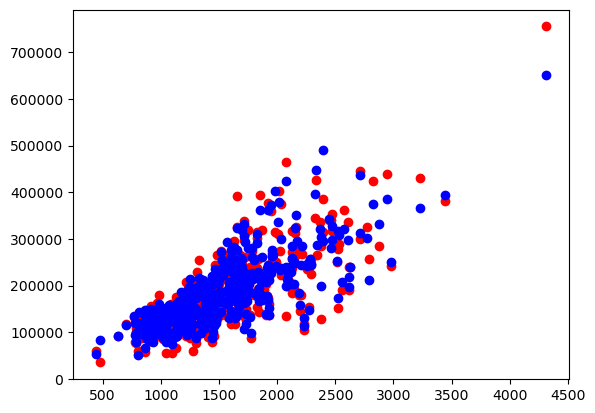

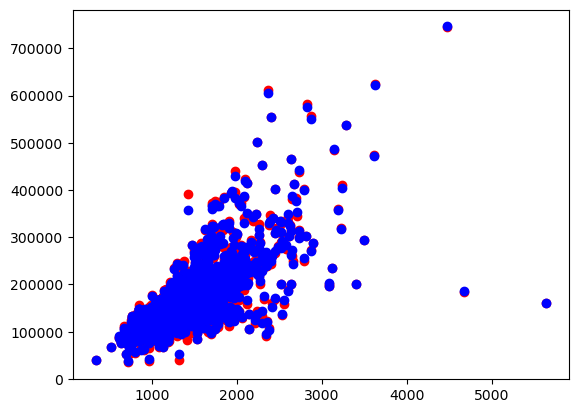

In [8]:
model = trainmodel(data_cleaned)


In [9]:
def testmodel(rf_regressor,data_cleaned):
  # X = data_cleaned.drop('SalePrice', axis = 1)
  X = data_cleaned
  # Y = pd.DataFrame(data_cleaned['SalePrice'])
  # from sklearn.model_selection import train_test_split
  # X_train, X_test, y_train, y_test = train_test_split( X, Y,test_size=0.3, random_state=0)
  # rf_regressor = RandomForestRegressor(n_estimators = 50, random_state = 0,max_features=20)
  # rf_regressor.fit(X, Y)
  y_pred_train = rf_regressor.predict(X)
  # print(r2_score(Y, y_pred_train))
  fig, ax = plt.subplots()
  # ax.scatter(X['GrLivArea'],Y, color = "red")
  ax.scatter(X['GrLivArea'],y_pred_train, color = "blue")
  return y_pred_train

In [10]:
Tdata_cleaned = cleanData(data_test)
# data_cleaned

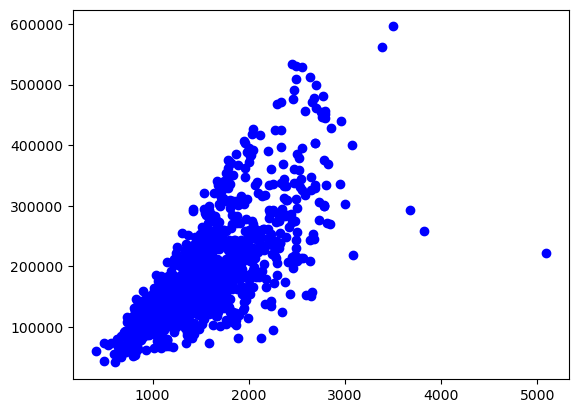

In [11]:
y_pred = testmodel(model,Tdata_cleaned)


In [12]:
TestPredicted = data_test
TestPredicted['SalePrice'] = pd.DataFrame(y_pred).round(0).astype(int)
TestPredicted.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,83421
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,80150
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,156715
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,119692
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,223841


In [13]:
SubmissionData = pd.concat([TestPredicted['Id'],TestPredicted['SalePrice']],axis=1)
SubmissionData.head()

,Id,SalePrice
0,1461,126148
1,1462,166418
2,1463,178596
3,1464,192799
4,1465,182283


In [14]:
SubmissionData.head()

,Id,SalePrice
0,1461,126148
1,1462,166418
2,1463,178596
3,1464,192799
4,1465,182283


In [15]:
SubmissionData.to_csv('submission_HousePrice2.csv', encoding='utf-8', index=False)

In [16]:
SubmissionData.shape
data_test.shape

(1459, 81)

In [17]:
from matplotlib import pyplot as plt
def show_distribution(var_data):
    '''
    This function will make a distribution (graph) and display it
    '''

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(var_data.name)

    # Show the figure
    fig.show()

In [18]:
def show_density(var_data):
    fig = plt.figure(figsize=(10,4))

    # Plot density
    var_data.plot.density()

    # Add titles and labels
    plt.title(var_data.name)

    # Show the mean, median, and mode
    plt.axvline(x=var_data.mean(), color = 'cyan', linestyle='dashed', linewidth = 2)
    plt.axvline(x=var_data.median(), color = 'red', linestyle='dashed', linewidth = 2)
    plt.axvline(x=var_data.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2)

    # Show the figure
    plt.show()

In [19]:
# show_distribution(data_cleaned['SalePrice'])